In [1]:
# https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb

In [2]:
# Load dataset
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='../data/train_CRM_data.json', split='train')
eval_dataset = load_dataset('json', data_files='../data/val_CRM_data.json', split='train')
test_dataset = load_dataset('json', data_files='../data/test_CRM_data.json', split='train')

In [3]:
# Formatting prompts
def formatting_func(message):
    # Extracting question, context, and answer from the message
    question = message[1]['content']
    context = message[0]['content']
    answer = message[2]['content']

    # Formatting the extracted information into text format
    text_format = f"""
### Question: {question}

### Context: {context}
### Answer: 
{answer}
    """

    return text_format.strip()

print(f"""
Raw message:

{train_dataset[0]['messages']}

Formatted message:

{formatting_func(train_dataset[0]['messages'])}
""")


Raw message:

[{'content': '\nYou are a Python function generator. Users will ask you questions in English, \nand you will produce a Python function as answer to the question based on the provided CONTEXT.\n\nCONTEXT:\nPandas DataFrame df containing transaction data with columns order_id, user_id, item_id, timestamp, score.\r\norder_id takes string datatype and identifies the order.\r\nuser_id takes string datatype and identifies the customer.\r\nitem_id takes string datatype that identifies the product.\r\ntimestamp takes timestamp datatype and represents the datetimestamp of transaction.\r\nscore takes float datatype and represents the score of the transaction.\r\nNote that a customer can make multiple transactions for a product but the customer product pair will be just one entry for each order.\r\nPandas DataFrame customer_dfcontaining customer data with columns user_id, customer_city.\r\nuser_id takes string datatype and identifies the customer.\r\ncustomer_city takes string data

In [4]:
# Setup Accelerator - Optional
from accelerate import (
    FullyShardedDataParallelPlugin, 
    Accelerator
)
from torch.distributed.fsdp.fully_sharded_data_parallel import (
    FullOptimStateDictConfig, 
    FullStateDictConfig
)

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(
        offload_to_cpu=True, 
        rank0_only=False
    ),
    optim_state_dict_config=FullOptimStateDictConfig(
        offload_to_cpu=True, 
        rank0_only=False
    ),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [5]:
# Setup weights and biases training metrics tracking

##### WARNING #####
# Ignore the below warning for now as it doesn't affect the functionality of wandb metric collection in any way.
# Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
##### ####### #####

import wandb
import os

wandb.login()

wandb_project = "finetune-mistral-01"
wandb_notebook_name = "01_finetune_mistral.ipynb"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project
    os.environ["WANDB_NOTEBOOK_NAME"] = wandb_notebook_name

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nayan4qmul (nayan4learn). Use `wandb login --relogin` to force relogin


In [6]:
# Load base model
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig
)

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    quantization_config=bnb_config, 
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# Setup Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [8]:
# Reformat prompt and tokenize each message
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenized_train_dataset = list(map(lambda record: generate_and_tokenize_prompt(record['messages']), train_dataset))
tokenized_val_dataset = list(map(lambda record: generate_and_tokenize_prompt(record['messages']), eval_dataset))

370


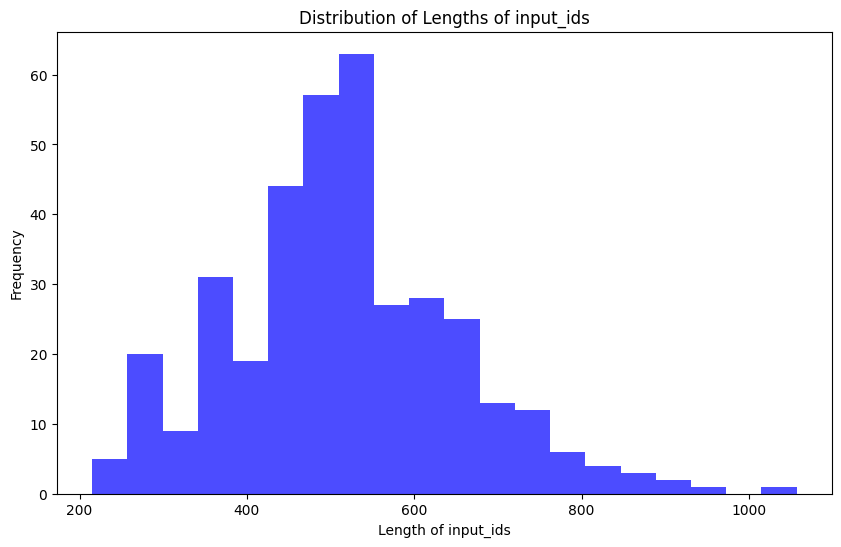

In [9]:
# Plot the distribution of sample length
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

370


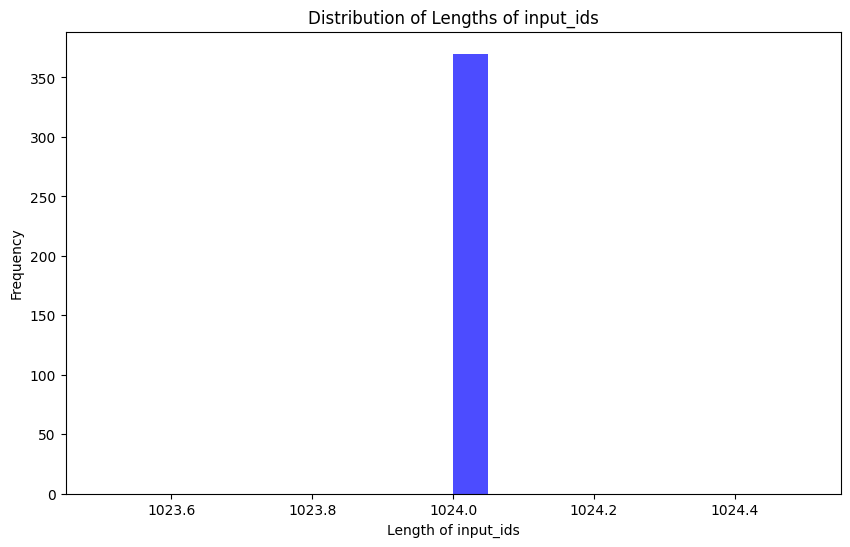

In [10]:
max_length = 1024 # This was an appropriate max length for my dataset

# Reformat prompt and tokenize each message with truncation
def generate_and_tokenize_prompt_with_trunc(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset = list(map(lambda record: generate_and_tokenize_prompt_with_trunc(record['messages']), train_dataset))
tokenized_val_dataset = list(map(lambda record: generate_and_tokenize_prompt_with_trunc(record['messages']), eval_dataset))

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
# check base model performance
prompt = formatting_func(eval_dataset[0]['messages'])

# Find the index of "### Answer:"
index_answer = prompt.find("### Answer:")

# Extract the string up to "### Answer:"
eval_prompt = prompt[:index_answer + len("### Answer:")].strip()

print(f"""
Complete message:

{prompt}

Prompt for text-generation:

{eval_prompt}
""")


Complete message:

### Question: What is the correlation between transaction scores and customer city, as well as product category during peak hours, specifically from 8 AM to 10 AM?

### Context: 
You are a Python function generator. Users will ask you questions in English, 
and you will produce a Python function as answer to the question based on the provided CONTEXT.

CONTEXT:
Pandas DataFrame df containing transaction data with columns order_id, user_id, item_id, timestamp, score.
order_id takes string datatype and identifies the order.
user_id takes string datatype and identifies the customer.
item_id takes string datatype that identifies the product.
timestamp takes timestamp datatype and represents the datetimestamp of transaction.
score takes float datatype and represents the score of the transaction.
Note that a customer can make multiple transactions for a product but the customer product pair will be just one entry for each order.
Pandas DataFrame customer_dfcontaining cust

In [12]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(
    eval_prompt, 
    return_tensors="pt"
).to("cuda")

model.eval()

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [13]:
with torch.no_grad():
    print(
        eval_tokenizer.decode(
            model.generate(
                **model_input, 
                max_new_tokens=1024, 
                repetition_penalty=1.15, 
                pad_token_id=eval_tokenizer.eos_token_id
            )[0], 
            skip_special_tokens=True
        )
    )

### Question: What is the correlation between transaction scores and customer city, as well as product category during peak hours, specifically from 8 AM to 10 AM?

### Context: 
You are a Python function generator. Users will ask you questions in English, 
and you will produce a Python function as answer to the question based on the provided CONTEXT.

CONTEXT:
Pandas DataFrame df containing transaction data with columns order_id, user_id, item_id, timestamp, score.
order_id takes string datatype and identifies the order.
user_id takes string datatype and identifies the customer.
item_id takes string datatype that identifies the product.
timestamp takes timestamp datatype and represents the datetimestamp of transaction.
score takes float datatype and represents the score of the transaction.
Note that a customer can make multiple transactions for a product but the customer product pair will be just one entry for each order.
Pandas DataFrame customer_dfcontaining customer data with colum

In [14]:
# Setup LoRA - "Low Rank Adaptation"
# https://arxiv.org/abs/2106.09685v2 
# This is a lossy method but established to provisde quite good performance
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [15]:
# Define LoRA config
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 170082304 || all params: 3922153472 || trainable%: 4.336452033664837


In [16]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

In [17]:
# Enable parallelisation if multiple GPUs available
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

In [18]:
# Use accelerator
model = accelerator.prepare_model(model)

In [19]:
# Train model
##### WARNING #####
# Ignore the below warning probably generated by the data_collator
# You're using a LlamaTokenizerFast tokenizer. 
# Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
#
# Ignore the below warning based on the Lora config setup.
# UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
#  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
##### ####### #####
import transformers
from datetime import datetime

iter_str = "01"
project = "finetune"
base_model_name = "mistral"
run_name = iter_str + "-" + project + "-" + base_model_name
output_dir = "../models/" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant":True},
        max_steps=500,
        learning_rate=2.5e-5,                                              # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,                                                  # When to start reporting loss
        logging_dir="./logs",                                              # Directory for storing logs
        save_strategy="steps",                                             # Save the model checkpoint every logging step
        save_steps=25,                                                     # Save checkpoints every 25 steps
        evaluation_strategy="steps",                                       # Evaluate the model every logging step
        eval_steps=25,                                                     # Evaluate and save checkpoints every 25 steps
        do_eval=True,                                                      # Perform evaluation at the end of training
        report_to="wandb",                                                 # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}" # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, 
        mlm=False
    ),
)

model.config.use_cache = False                                             # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
25,0.830600,0.362868
50,0.259100,0.213522
75,0.201800,0.193632
100,0.179200,0.179639
125,0.177800,0.171921
150,0.179400,0.167416
175,0.150400,0.163380
200,0.140000,0.160474
225,0.121300,0.160498
250,0.140900,0.158252


/home/jovyan/LLM_CRM_PERSO/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/jovyan/LLM_CRM_PERSO/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/jovyan/LLM_CRM_PERSO/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/jovyan/LLM_CRM_PERSO/.venv/lib/python3.10/site-packages/peft/utils/save_and_loa

TrainOutput(global_step=500, training_loss=0.17961270523071288, metrics={'train_runtime': 868.9765, 'train_samples_per_second': 1.151, 'train_steps_per_second': 0.575, 'total_flos': 4.45986826616832e+16, 'train_loss': 0.17961270523071288, 'epoch': 3.03})

In [1]:
# Load base model for inference
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig
)

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    quantization_config=bnb_config, 
    device_map="auto"
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id, 
    add_bos_token=True, 
    trust_remote_code=True
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "../models/01-finetune-mistral/checkpoint-150")

In [3]:
# Load dataset
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='../data/train_CRM_data.json', split='train')
eval_dataset = load_dataset('json', data_files='../data/val_CRM_data.json', split='train')
test_dataset = load_dataset('json', data_files='../data/test_CRM_data.json', split='train')

# Formatting prompts
def formatting_func(message):
    # Extracting question, context, and answer from the message
    question = message[1]['content']
    context = message[0]['content']
    answer = message[2]['content']

    # Formatting the extracted information into text format
    text_format = f"""
### Question: {question}

### Context: {context}
### Answer: 
{answer}
    """

    return text_format.strip()

# check base model performance
prompt = formatting_func(eval_dataset[0]['messages'])

# Find the index of "### Answer:"
index_answer = prompt.find("### Answer:")

# Extract the string up to "### Answer:"
eval_prompt = prompt[:index_answer + len("### Answer:")].strip()

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(
    eval_prompt, 
    return_tensors="pt"
).to("cuda")

ft_model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

In [4]:
with torch.no_grad():
    print(
        eval_tokenizer.decode(
            ft_model.generate(
                **model_input, 
                max_new_tokens=1024, 
                repetition_penalty=1.15, 
                pad_token_id=eval_tokenizer.eos_token_id
            )[0], 
            skip_special_tokens=True
        )
    )

### Question: What is the correlation between transaction scores and customer city, as well as product category during peak hours, specifically from 8 AM to 10 AM?

### Context: 
You are a Python function generator. Users will ask you questions in English, 
and you will produce a Python function as answer to the question based on the provided CONTEXT.

CONTEXT:
Pandas DataFrame df containing transaction data with columns order_id, user_id, item_id, timestamp, score.
order_id takes string datatype and identifies the order.
user_id takes string datatype and identifies the customer.
item_id takes string datatype that identifies the product.
timestamp takes timestamp datatype and represents the datetimestamp of transaction.
score takes float datatype and represents the score of the transaction.
Note that a customer can make multiple transactions for a product but the customer product pair will be just one entry for each order.
Pandas DataFrame customer_dfcontaining customer data with colum

In [9]:
print(prompt[index_answer:].strip()) ### Original solution - Ground truth

### Answer: 
def correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10]):\n    df = pd.merge(df, customer_df, on='user_id', how='left')\n    df = pd.merge(df, product_df, on='item_id', how='left')\n    peak_hour_transactions = df[df['timestamp'].dt.hour.isin(peak_hours)]\n    city_scores = peak_hour_transactions.groupby('customer_city')['score'].mean()\n    category_scores = peak_hour_transactions.groupby('product_category')['score'].mean()\n    city_correlation = peak_hour_transactions.groupby('customer_city')['score'].corr(city_scores)\n    category_correlation = peak_hour_transactions.groupby('product_category')['score'].corr(category_scores)\n    return city_correlation, category_correlation\n


In [12]:
print("Generated Solution:\n")
print("""def correlate_transaction_scores(df, customer_df, product_df):\n    merged_df = pd.merge(df, customer_df, on='user_id')\n    merged_df = pd.merge(merged_df, product_df, on='item_id')\n    merged_df['hour'] = merged_df['timestamp'].dt.hour\n    hourly_transactions = merged_df[merged_df['hour'] >= 8]\n    hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)\n    if 'peak_hours' not in hourly_transactions.columns:\n        hourly_transactions['peak_hours'] = False\n    return hourly_transactions.groupby(['customer_city', 'product_category', 'peak_hours'])['score'].mean().unstack()\n
correlate_transaction_scores(df, customer_df, product_df).plot(kind='bar', stacked=True, figsize=(12, 6))\nplt.title('Correlation Between Transaction Scores and Customer City/Product Category During Peak Hours')\nplt.xlabel('Customer City/Product Category')\nplt.ylabel('Average Score')\nplt.legend(loc='best')\nplt.show()""")

Generated Solution:

def correlate_transaction_scores(df, customer_df, product_df):
    merged_df = pd.merge(df, customer_df, on='user_id')
    merged_df = pd.merge(merged_df, product_df, on='item_id')
    merged_df['hour'] = merged_df['timestamp'].dt.hour
    hourly_transactions = merged_df[merged_df['hour'] >= 8]
    hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)
    if 'peak_hours' not in hourly_transactions.columns:
        hourly_transactions['peak_hours'] = False
    return hourly_transactions.groupby(['customer_city', 'product_category', 'peak_hours'])['score'].mean().unstack()

correlate_transaction_scores(df, customer_df, product_df).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Correlation Between Transaction Scores and Customer City/Product Category During Peak Hours')
plt.xlabel('Customer City/Product Category')
plt.ylabel('Average Score')
plt.legend(loc='best')
plt.show()


In [13]:
print("Original Solution:\n")
print("""def correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10]):\n    df = pd.merge(df, customer_df, on='user_id', how='left')\n    df = pd.merge(df, product_df, on='item_id', how='left')\n    peak_hour_transactions = df[df['timestamp'].dt.hour.isin(peak_hours)]\n    city_scores = peak_hour_transactions.groupby('customer_city')['score'].mean()\n    category_scores = peak_hour_transactions.groupby('product_category')['score'].mean()\n    city_correlation = peak_hour_transactions.groupby('customer_city')['score'].corr(city_scores)\n    category_correlation = peak_hour_transactions.groupby('product_category')['score'].corr(category_scores)\n    return city_correlation, category_correlation\n""")

Original Solution:

def correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10]):
    df = pd.merge(df, customer_df, on='user_id', how='left')
    df = pd.merge(df, product_df, on='item_id', how='left')
    peak_hour_transactions = df[df['timestamp'].dt.hour.isin(peak_hours)]
    city_scores = peak_hour_transactions.groupby('customer_city')['score'].mean()
    category_scores = peak_hour_transactions.groupby('product_category')['score'].mean()
    city_correlation = peak_hour_transactions.groupby('customer_city')['score'].corr(city_scores)
    category_correlation = peak_hour_transactions.groupby('product_category')['score'].corr(category_scores)
    return city_correlation, category_correlation



In [14]:
# Import Libraries
import pandas as pd
import random
from faker import Faker
fake = Faker()

# List of famous European city names as customer city
european_cities = [
    'London', 'Paris'
]

# Generate sample data for transactions / orders
orders_data = []
for i in range(1, 16):
    order_id = f'order{i}'
    user_id = f'user{random.randint(1, 5)}'
    item_id = f'item{random.randint(1, 3)}'
    timestamp = fake.date_time_between(start_date='-5d', end_date='now')
    score = round(random.uniform(0.5, 1.0), 2)
    orders_data.append({'order_id': order_id, 'user_id': user_id, 'item_id': item_id, 'timestamp': timestamp, 'score': score})
orig_df = pd.DataFrame(orders_data)

# Generate sample data for customers / users
customers_data = []
for i in range(1, 6):
    user_id = f'user{i}'
    customer_city = random.choice(european_cities)
    customers_data.append({'user_id': user_id, 'customer_city': customer_city})
orig_customer_df = pd.DataFrame(customers_data).drop_duplicates(subset=['user_id'])

# Generate sample data for products
products_data = []
for i in range(1, 6):
    item_id = f'item{i}'
    product_category = fake.word()
    products_data.append({'item_id': item_id, 'product_category': product_category})
orig_product_df = pd.DataFrame(products_data).drop_duplicates(subset=['item_id'])

def data_copy(orig_df, orig_customer_df, orig_product_df):
    """
    Copy the original dataframes to new ones.

    Args:
    - orig_df (pandas DataFrame): The original dataframe to be copied.
    - orig_customer_df (pandas DataFrame): The original customer dataframe to be copied.
    - orig_product_df (pandas DataFrame): The original product dataframe to be copied.

    Returns:
    - df (pandas DataFrame): A deep copy of the original dataframe.
    - customer_df (pandas DataFrame): A deep copy of the original customer dataframe.
    - product_df (pandas DataFrame): A deep copy of the original product dataframe.
    """
    df = orig_df.copy(deep=True)
    customer_df = orig_customer_df.copy(deep=True)
    product_df = orig_product_df.copy(deep=True)
    return df, customer_df, product_df

df, customer_df, product_df = data_copy(orig_df, orig_customer_df, orig_product_df)

# Displaying sample data
print("Orders Data:")
print(df)
print("\nCustomer Data:")
print(customer_df)
print("\nProduct Data:")
print(product_df)

Orders Data:
   order_id user_id item_id                  timestamp  score
0    order1   user2   item1 2024-04-16 05:34:57.611672   0.66
1    order2   user5   item3 2024-04-17 09:12:06.048336   0.68
2    order3   user1   item2 2024-04-18 04:42:01.560851   0.56
3    order4   user3   item3 2024-04-18 07:55:22.184441   0.53
4    order5   user1   item3 2024-04-16 09:12:47.161910   0.82
5    order6   user3   item1 2024-04-17 17:34:46.447163   0.66
6    order7   user1   item2 2024-04-17 09:24:52.520001   0.73
7    order8   user4   item3 2024-04-17 11:41:17.672311   0.68
8    order9   user2   item2 2024-04-16 02:14:13.695675   0.75
9   order10   user1   item1 2024-04-16 21:23:48.759970   0.59
10  order11   user5   item2 2024-04-20 13:51:29.422813   0.65
11  order12   user2   item2 2024-04-19 15:24:43.327376   0.73
12  order13   user4   item3 2024-04-19 20:38:25.001724   0.52
13  order14   user4   item2 2024-04-16 07:03:49.620218   0.86
14  order15   user1   item1 2024-04-17 09:47:14.957454   

/tmp/ipykernel_1130/3621278173.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)


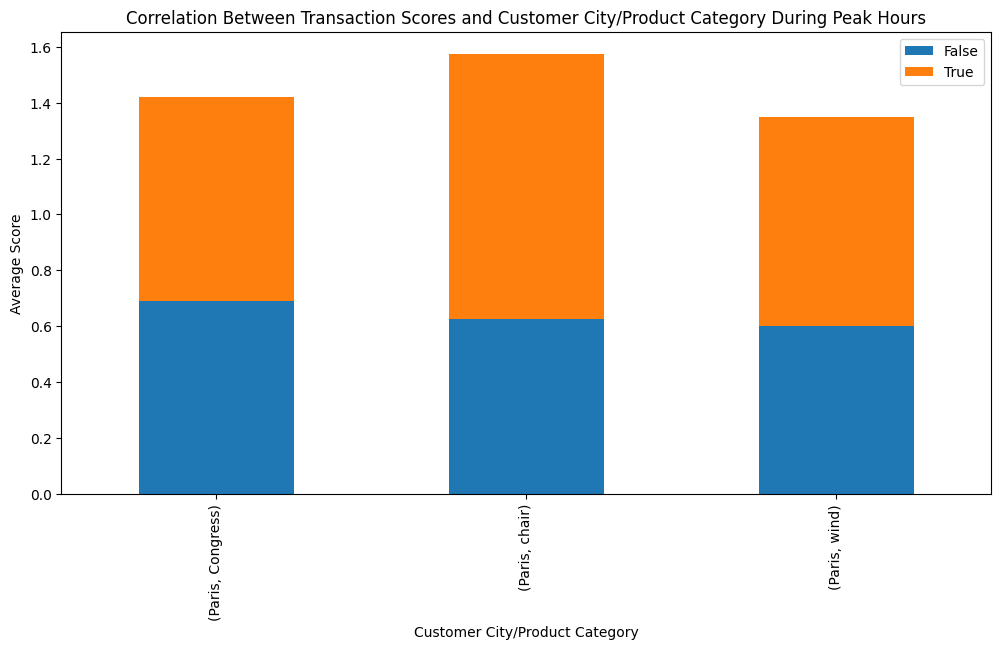


Original Solution:

(customer_city
Paris   NaN
Name: score, dtype: float64, product_category
Congress   NaN
chair      NaN
wind       NaN
Name: score, dtype: float64)

Generated Solution:

peak_hours                      False  True 
customer_city product_category              
Paris         Congress          0.690   0.73
              chair             0.625   0.95
              wind              0.600   0.75



/tmp/ipykernel_1130/3621278173.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)


In [16]:
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from itertools import combinations
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from surprise import Reader, Dataset
from surprise.prediction_algorithms import SVD
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import pandas as pd

def correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10]):
    df = pd.merge(df, customer_df, on='user_id', how='left')
    df = pd.merge(df, product_df, on='item_id', how='left')
    peak_hour_transactions = df[df['timestamp'].dt.hour.isin(peak_hours)]
    city_scores = peak_hour_transactions.groupby('customer_city')['score'].mean()
    category_scores = peak_hour_transactions.groupby('product_category')['score'].mean()
    city_correlation = peak_hour_transactions.groupby('customer_city')['score'].corr(city_scores)
    category_correlation = peak_hour_transactions.groupby('product_category')['score'].corr(category_scores)
    return city_correlation, category_correlation

original_res = correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10])

def correlate_transaction_scores(df, customer_df, product_df):
    merged_df = pd.merge(df, customer_df, on='user_id')
    merged_df = pd.merge(merged_df, product_df, on='item_id')
    merged_df['hour'] = merged_df['timestamp'].dt.hour
    hourly_transactions = merged_df[merged_df['hour'] >= 8]
    hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)
    if 'peak_hours' not in hourly_transactions.columns:
        hourly_transactions['peak_hours'] = False
    return hourly_transactions.groupby(['customer_city', 'product_category', 'peak_hours'])['score'].mean().unstack()

correlate_transaction_scores(df, customer_df, product_df).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Correlation Between Transaction Scores and Customer City/Product Category During Peak Hours')
plt.xlabel('Customer City/Product Category')
plt.ylabel('Average Score')
plt.legend(loc='best')
plt.show()

generated_res = correlate_transaction_scores(df, customer_df, product_df)

print(f"""
Original Solution:

{original_res}

Generated Solution:

{generated_res}
""")